<img src='images/vpython.png' width="230px">

# <font color='#333333'>Iris Dataset<font>
## <font color='#333333'>A Vertica ML Python tutorial to understand how to use the library.<font>

The Iris flower data set or Fisher's Iris data set is a multivariate data set introduced by the British statistician and biologist Ronald Fisher in his 1936 paper The use of multiple measurements in taxonomic problems as an example of linear discriminant analysis. <br>

The data set consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimetres. Based on the combination of these four features, Fisher developed a linear discriminant model to distinguish the species from each other.

<img src='images/irises.png' width="600px">

### <font color='#555555'>Connection to the Vertica Database using a DSN.<font>
    
In order to use the Vertica ML Python Library and begin the searches, we need first to connect to the Vertica Database. We can use an ODBC connection using a DSN.

In [1]:
import pyodbc
cur=pyodbc.connect("DSN=VerticaDSN").cursor() # It is the cursor used for all the queries to our Database.

### <font color='#555555'>Initialization<font>

We can now import the VPython library and especially the RVD (Resilient Vertica Dataset) object.

In [2]:
from vertica_ml_python import RVD
from vertica_ml_python import read_csv # This function will help us to load the csv file in the Database.
from vertica_ml_python import drop_table # This function will help us to drop the unnecessary tables. 

Let's now drop the table iris from our Database (if it exists) in order to use the read_csv parser.

In [3]:
drop_table("Iris",cur)

The table Iris was successfully dropped.


Let's now try to parse the csv files.

In [4]:
iris=read_csv('../datasets/Iris.csv',cur)

The parser guess the following columns and types:
Id: Integer
PetalLengthCm: Numeric(5,2)
PetalWidthCm: Numeric(5,2)
SepalLengthCm: Numeric(5,2)
SepalWidthCm: Numeric(5,2)
Species: Varchar(30)
Illegal characters in the columns names will be erased.
Is any type wrong?
If one of the types is not correct, it will be considered as Varchar(100).
0 - There is one type that I want to modify.
1 - I wish to continue.
2 - I wish to see the columns and their types again.
1
The table Iris has been successfully created.


If the table is already in the Database. We can create the RVD as follows:

In [5]:
iris=RVD('Iris',cur)

We can also create the RVD using directly the DSN:

In [6]:
iris=RVD('Iris',dsn="VerticaDSN")

### <font color='#555555'>Data Exploration and Cleaning<font>

Great, we have now our RVD object. All its methods will send SQL queries directly to Vertica in order to compute all the aggregations needed. In that case, nothing is loaded inside our machine except the final results computed by Vertica. All the users transformations are kept in mind and then used to send the final query. 

During this tutorial, we will try to understand the object thanks to this small dataset. Let first see what it looks like.

In [7]:
iris.head(5)

,Id,PetalLengthCm,PetalWidthCm,SepalLengthCm,SepalWidthCm,Species
0,1,1.40,0.20,5.10,3.50,Iris-setosa
1,2,1.40,0.20,4.90,3.00,Iris-setosa
2,3,1.30,0.20,4.70,3.20,Iris-setosa
3,4,1.50,0.20,4.60,3.10,Iris-setosa
4,5,1.40,0.20,5.00,3.60,Iris-setosa
,...,...,...,...,...,...


Name: Iris, Number of rows: 150, Number of columns: 6


The column Id is useless, we can drop it.

In [8]:
iris["Id"].drop_column()

RVC 'Id' deleted from the RVD.


In this dataset, we have four relevant columns that will be used for predictions.

In [9]:
iris.describe()

,count,mean,std,min,25%,50%,75%,max,cardinality
PetalLengthCm,150,3.75866666666667,1.76442041995226,1.0,1.6,4.35,5.1,6.9,43
PetalWidthCm,150,1.19866666666667,0.763160741700841,0.1,0.3,1.3,1.8,2.5,22
SepalLengthCm,150,5.84333333333333,0.828066127977864,4.3,5.1,5.8,6.4,7.9,35
SepalWidthCm,150,3.054,0.433594311362174,2.0,2.8,3.0,3.3,4.4,23


<column_matrix>

In this dataset, there is no outliers and no missing values as the biologist Ronald Fisher measured himself all the flowers.

In [10]:
iris.missing()

,total,percent
Species,0,0.0
SepalLengthCm,0,0.0
PetalWidthCm,0,0.0
PetalLengthCm,0,0.0
SepalWidthCm,0,0.0


<column_matrix>

Let's explore a little deeper the dataset.

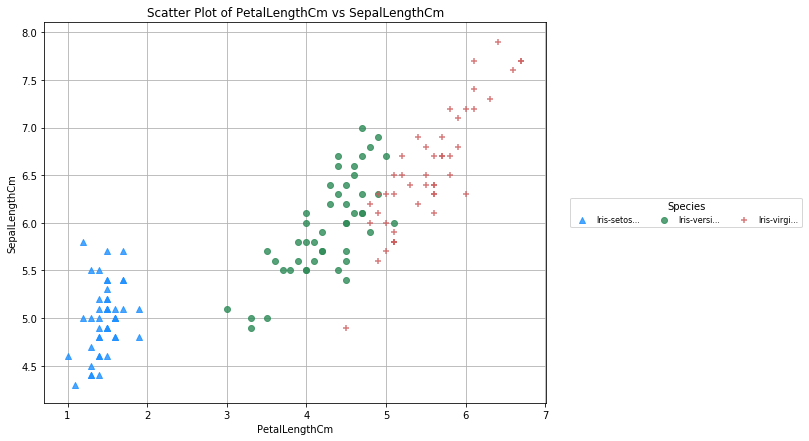

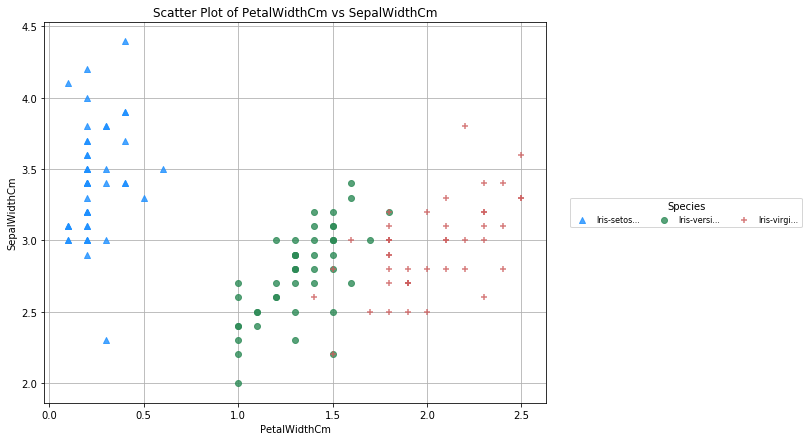

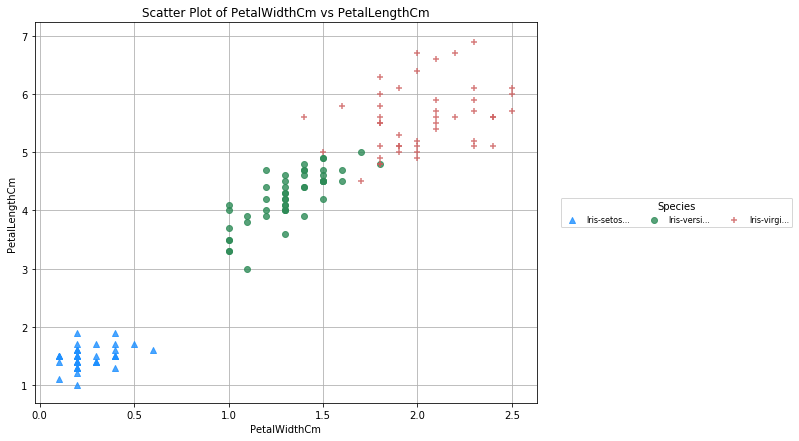

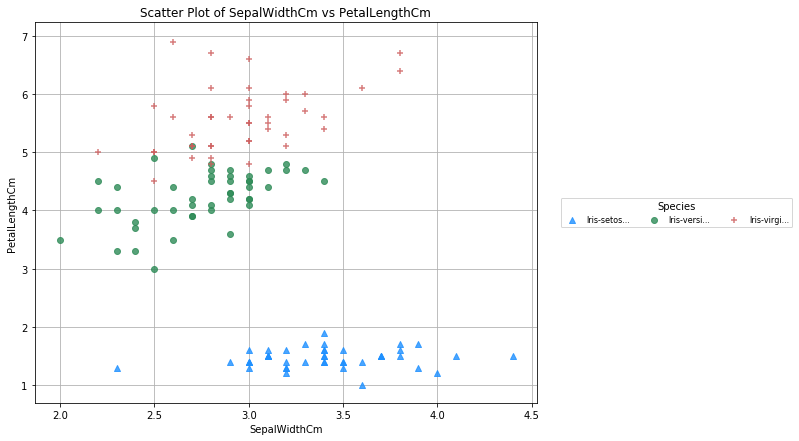

In [11]:
iris.scatter(columns=["PetalLengthCm","SepalLengthCm","Species"])
iris.scatter(columns=["PetalWidthCm","SepalWidthCm","Species"])
iris.scatter(columns=["PetalWidthCm","PetalLengthCm","Species"])
iris.scatter(columns=["SepalWidthCm","PetalLengthCm","Species"])

Wow, there is really a border between each species! Let's see some 3D plots.

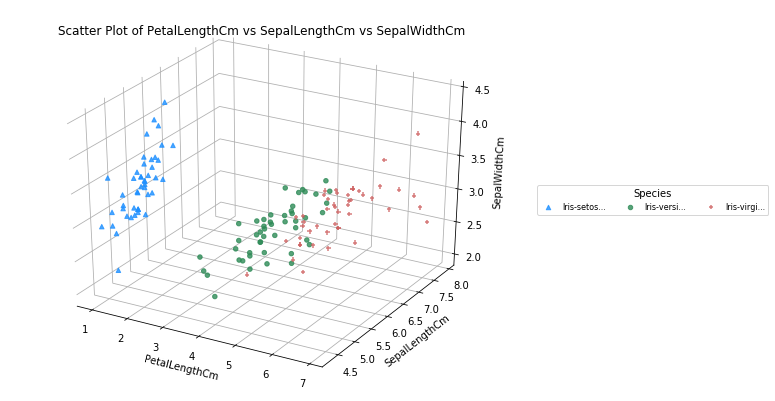

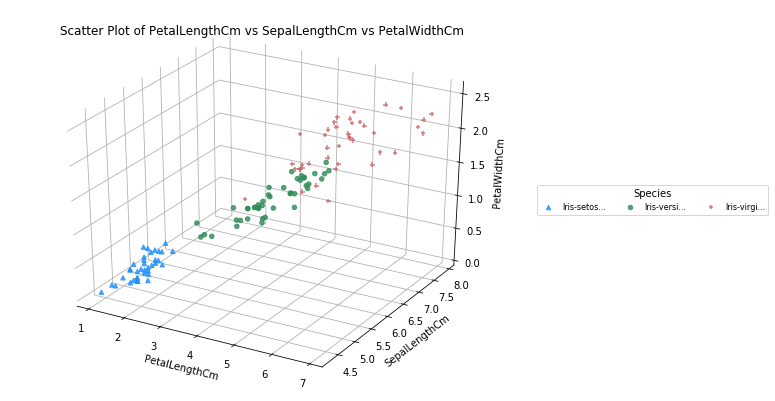

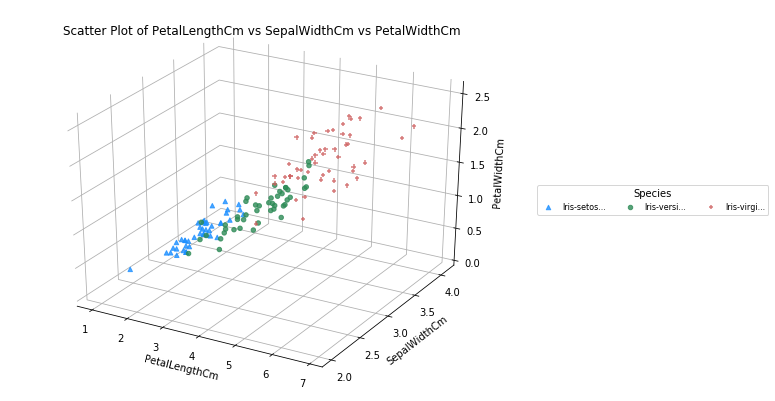

In [12]:
iris.scatter(columns=["PetalLengthCm","SepalLengthCm","SepalWidthCm","Species"])
iris.scatter(columns=["PetalLengthCm","SepalLengthCm","PetalWidthCm","Species"])
iris.scatter(columns=["PetalLengthCm","SepalWidthCm","PetalWidthCm","Species"])

Iris setosa flowers are very easy to predict. However, some of the two other species can be hard to predict. In order to do so, many algorithms are possibles:
<ul>
    <li>Logistic Regression or SVM using the one hot encoding of our 3 species
    <li>Naive Bayes or Random Forest 
    <li>Kmeans with 3 clusters
</ul>
First we will use a Kmeans Clustering to try to predict the 3 species. After we will use the SVM in order to see how we can predict variables of multiple classes using a binary classifier.

### <font color='#555555'>Kmeans Clustering<font>
First let's import the Kmeans algorithm.

In [13]:
from vertica_ml_python import kmeans
from vertica_ml_python import drop_model

drop_model("iris_kmeans",cur)

The model iris_kmeans was successfully dropped.


We can see the optimal number of clusters using the elbow curve.

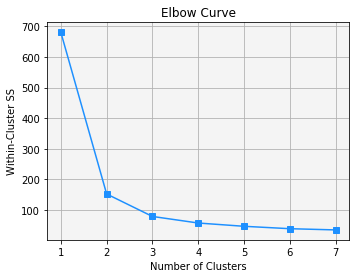

num_clusters,all_within_cluster_SS
1,680.8244
2,152.36871
3,78.945066
4,57.473273
5,46.801702
6,38.93874
7,34.968593


<column_matrix>

In [14]:
from vertica_ml_python import elbow
elbow(input_relation="Iris",input_columns=["PetalLengthCm","SepalLengthCm","PetalWidthCm","SepalWidthCm"],cursor=cur,
         max_num_cluster=8)

As expected, 3 is the optimal number of clusters as the all_within_cluster_SS decreases slowly after this point. We can then create the model.

In [15]:
iris_kmeans=kmeans(model_name="iris_kmeans",input_relation="Iris",
                   input_columns=["PetalLengthCm","SepalLengthCm","PetalWidthCm","SepalWidthCm"],
                   num_clusters=3,cursor=cur,initial_centers=[(1,2,3,4),(2,3,4,5),(3,4,5,6)])

Let's see what the model looks like.

,PetalLengthCm,SepalLengthCm,PetalWidthCm,SepalWidthCm
0,1.464,5.006,0.244,3.418
1,4.39354838709677,5.90161290322581,1.43387096774194,2.74838709677419
2,5.7421052631579,6.85,2.07105263157895,3.07368421052632


model_type='kmeans'
model_name='iris_kmeans'
input_relation='Iris'
input_columns='PetalLengthCm,SepalLengthCm,PetalWidthCm,SepalWidthCm'



,Cluster SS
0,15.2404
1,39.820968
2,23.879474


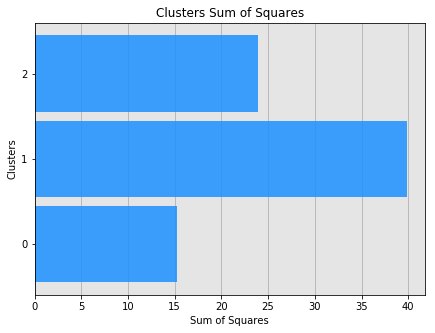

[15.2404, 39.820968, 23.879474]

In [16]:
print(iris_kmeans)
iris_kmeans.cluster_SS()

We can also see the importance of each feature.

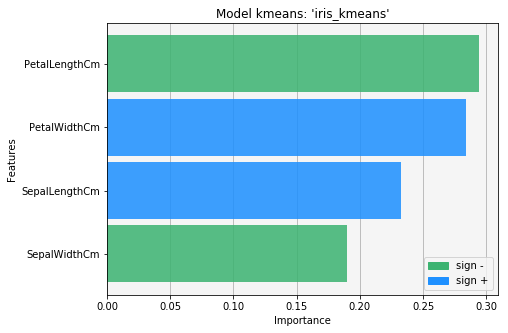

,Importance
SepalWidthCm,0.189935818337476
SepalLengthCm,0.23234341611857398
PetalWidthCm,0.2835830211296191
PetalLengthCm,0.294137744414331


<column_matrix>

In [17]:
iris_kmeans.features_importance()

Let's add the clusters to our RVD.

In [18]:
name=iris_kmeans.add_to_rvd(iris)
print(iris)

The new RVC 'kmeans_cluster1045' was added to the RVD.


,PetalLengthCm,PetalWidthCm,SepalLengthCm,SepalWidthCm,Species,kmeans_cluster1045
0,1.40,0.20,5.10,3.50,Iris-setosa,0
1,1.40,0.20,4.90,3.00,Iris-setosa,0
2,1.30,0.20,4.70,3.20,Iris-setosa,0
3,1.50,0.20,4.60,3.10,Iris-setosa,0
4,1.40,0.20,5.00,3.60,Iris-setosa,0
5,1.70,0.40,5.40,3.90,Iris-setosa,0
6,1.40,0.30,4.60,3.40,Iris-setosa,0
7,1.50,0.20,5.00,3.40,Iris-setosa,0
8,1.40,0.20,4.40,2.90,Iris-setosa,0
9,1.50,0.10,4.90,3.10,Iris-setosa,0


Name: Iris, Number of rows: 150, Number of columns: 6


As expected the Iris Setosa is perfectly predicted. Let's explore our new column.

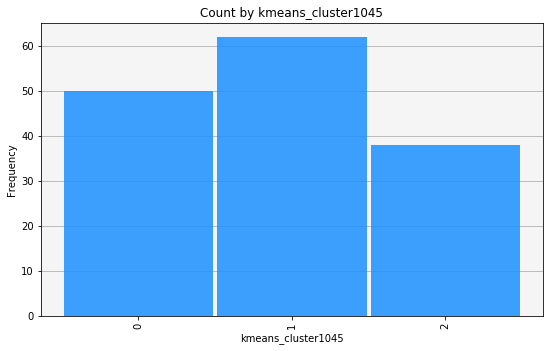

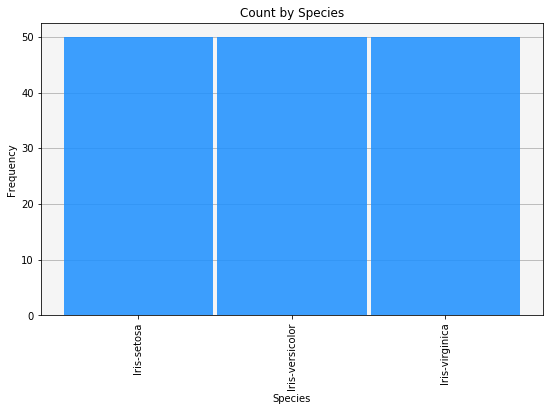

In [19]:
iris[name].hist(method="count")
iris["Species"].hist(method="count")

Let's compare the most interesting plots.

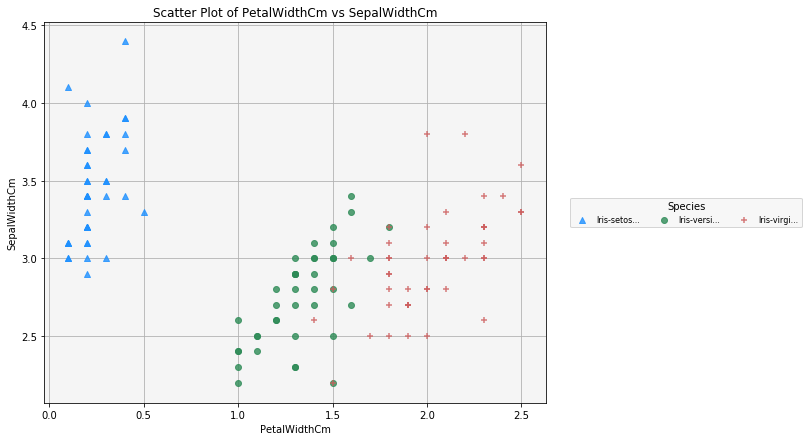

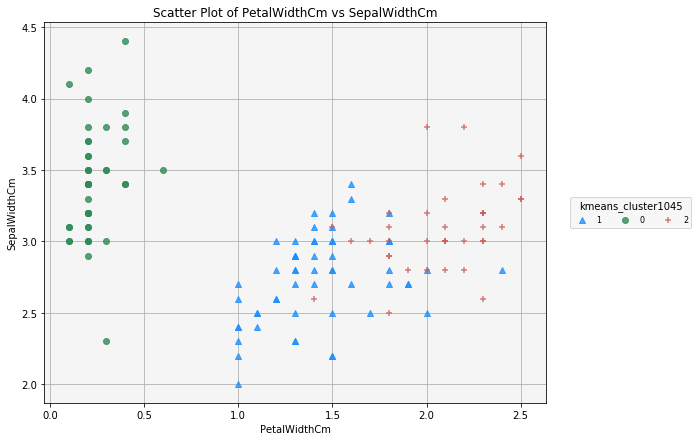

In [20]:
iris.scatter(columns=["PetalWidthCm","SepalWidthCm","Species"])
iris.scatter(columns=["PetalWidthCm","SepalWidthCm",name])

Okay! So cluster 0 is the Iris Setosa, 1 is the Iris Versicolor and 2 is the Iris Virginica. Iris Setosa is perfectly predicted while there are some mistakes for the two others. Let's see our accuracy.

In [21]:
iris["Species"].decode(["Iris-setosa","Iris-versicolor"],[0,1],2)
iris.add_feature("cluster_comparaison",iris[name].final_transformation()+"="+iris["Species"].final_transformation())
iris["cluster_comparaison"].describe()

The new RVC 'cluster_comparaison' was added to the RVD.


,value
t,134
f,16


<column_matrix>

We have an accuracy of {{round(134/150*100,2)}}% which is quite good. However, we can still improve it.

### <font color='#555555'>SVM Classification<font>
#### <font color='#666666'>SVM Classification on Iris Setosa<font>
Let's now try to see what we can do with the SVM classifier.

We must use the one hot encoder in order to have multiple binary variables.

3 new features: Species_Iris_setosa, Species_Iris_versicolor, Species_Iris_virginica


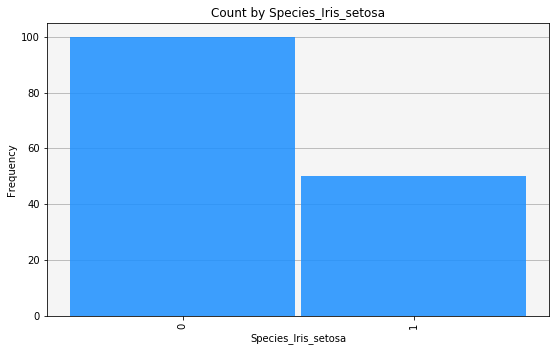

In [22]:
iris=RVD("Iris",dsn="VerticaDSN")
iris["Species"].one_hot_encoder()
iris["Species_Iris_setosa"].hist(method="count")

We can save our RVD as a view.

In [23]:
from vertica_ml_python import drop_view
drop_view("iris_temp",cur)
iris.save("iris_temp")

The view iris_temp was successfully dropped.
The RVD was successfully saved.


We can now try to find the hyperplan which will separate the data. We will create many SVM in order to see the plan in many different dimensions.



##### <font color='#555555'>SVM with only one feature<font>

The model svm_iris was successfully dropped.


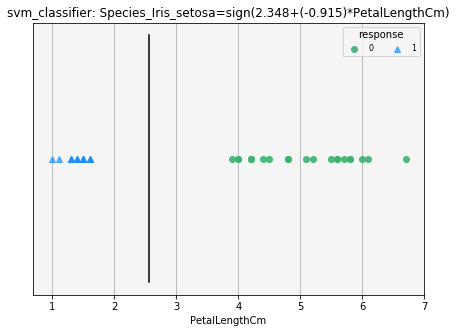

In [24]:
from vertica_ml_python import svm_classifier
drop_model("svm_iris",cur)
svm_iris=svm_classifier(model_name="svm_iris",input_relation="iris_temp",response_column="Species_Iris_setosa",
                   predictor_columns=["PetalLengthCm"],cursor=cur)
svm_iris.plot()

##### <font color='#555555'>SVM with only two features<font>

The model svm_iris was successfully dropped.


,coefficient
Intercept,0.22005691793408
petallengthcm,-1.21492250709494
sepallengthcm,0.563205058441283


model_type='svm_classifier'
model_name='svm_iris'
input_relation='iris_temp'
response_column='Species_Iris_setosa'
predictor_columns='PetalLengthCm,SepalLengthCm'
iteration_count: 6
rejected_row_count: 0
accepted_row_count: 150


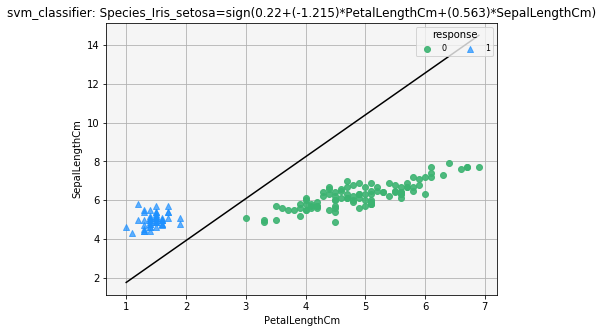

In [25]:
from vertica_ml_python import svm_classifier
drop_model("svm_iris",cur)
svm_iris=svm_classifier(model_name="svm_iris",input_relation="iris_temp",response_column="Species_Iris_setosa",
                   predictor_columns=["PetalLengthCm","SepalLengthCm",],cursor=cur)
print(svm_iris)
svm_iris.plot()

##### <font color='#555555'>SVM with three features<font>

The model svm_iris was successfully dropped.


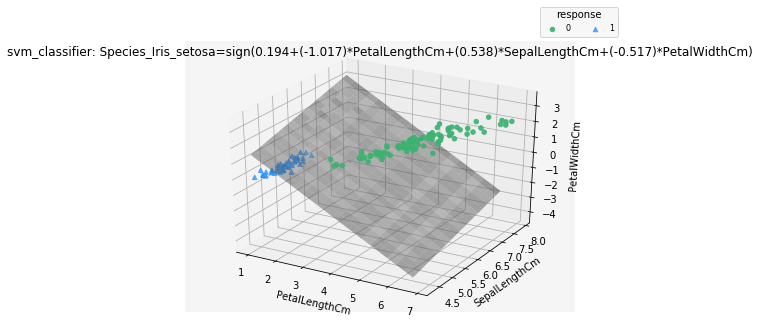

In [26]:
from vertica_ml_python import svm_classifier
drop_model("svm_iris",cur)
svm_iris=svm_classifier(model_name="svm_iris",input_relation="iris_temp",response_column="Species_Iris_setosa",
                   predictor_columns=["PetalLengthCm","SepalLengthCm","PetalWidthCm"],cursor=cur)
svm_iris.plot()

##### <font color='#555555'>SVM with four features<font>

In [27]:
from vertica_ml_python import svm_classifier
drop_model("svm_iris",cur)
svm_iris=svm_classifier(model_name="svm_iris",input_relation="iris_temp",response_column="Species_Iris_setosa",
                   predictor_columns=["PetalLengthCm","SepalLengthCm","PetalWidthCm","SepalWidthCm"],cursor=cur)
svm_iris

The model svm_iris was successfully dropped.


,coefficient
Intercept,0.0931563016679742
petallengthcm,-0.793729418803655
sepallengthcm,0.145248138440046
petalwidthcm,-0.374529786870006
sepalwidthcm,0.496642336015163


model_type='svm_classifier'
model_name='svm_iris'
input_relation='iris_temp'
response_column='Species_Iris_setosa'
predictor_columns='PetalLengthCm,SepalLengthCm,PetalWidthCm,SepalWidthCm'
iteration_count: 5
rejected_row_count: 0
accepted_row_count: 150

For this model, we can not plot the hyperplan (sorry I do not know the fourth dimension) but we wan see the importance of each feature.

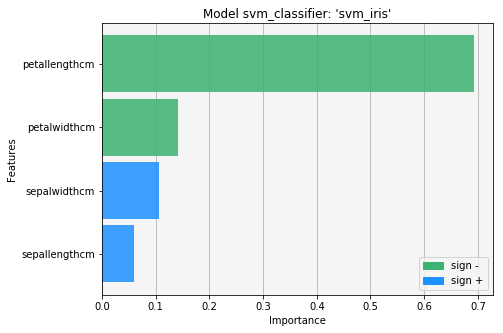

,Importance
sepallengthcm,0.05948571176665842
sepalwidthcm,0.10650362282443895
petalwidthcm,0.14136420400407973
petallengthcm,0.6926464614048229


<column_matrix>

In [28]:
svm_iris.features_importance()

As expected the Petal Length is very important. Let's see the model accuracy.

In [29]:
svm_iris.error_rate()

,error_rate
0,0.0
1,0.0
total,0.0


<column_matrix>

We can see that no matter the number of variables, we have an accuracy of 100%. Besides, we can see the hyperplan separating all the data perfectly. For this dataset, we can build a very easy model with only the Petal Length variable to predict if the specie is Iris Setosa. We can now try to see how to evaluate the others.

#### <font color='#666666'>SVM Classification on the two other species<font>
We must delete the Iris Setosa from our RVD.

In [30]:
iris=RVD('Iris',cur)
iris["Species"].decode(["Iris-setosa","Iris-versicolor"],[None,0],1)
iris["Species"].dropna()
iris["Species"].convert_to_num()

50 elements were dropped


We can now save our RVD.

In [31]:
drop_view("iris_temp",cur)
iris.save("iris_temp")

The view iris_temp was successfully dropped.
The RVD was successfully saved.


Let's now build our model.

In [32]:
from vertica_ml_python import svm_classifier
drop_model("svm_iris",cur)
svm_iris=svm_classifier(model_name="svm_iris",input_relation="iris_temp",response_column="Species",
                   predictor_columns=["PetalLengthCm","SepalLengthCm","PetalWidthCm","SepalWidthCm"],cursor=cur)
print(svm_iris)

The model svm_iris was successfully dropped.


,coefficient
Intercept,-1.71153221376208
petallengthcm,1.38128764635026
sepallengthcm,-0.850962938050926
petalwidthcm,1.86448405980504
sepalwidthcm,-0.985559931548558


model_type='svm_classifier'
model_name='svm_iris'
input_relation='iris_temp'
response_column='Species'
predictor_columns='PetalLengthCm,SepalLengthCm,PetalWidthCm,SepalWidthCm'
iteration_count: 6
rejected_row_count: 0
accepted_row_count: 100


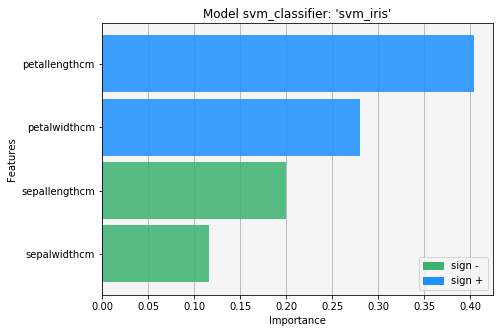

,Importance
sepalwidthcm,0.11611467875917439
sepallengthcm,0.19971027971236793
petalwidthcm,0.2804114164648016
petallengthcm,0.4037636250636561


<column_matrix>

In [33]:
svm_iris.features_importance()

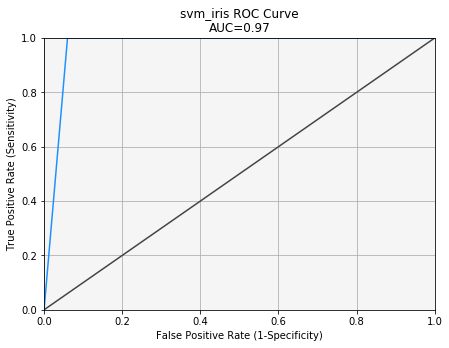

,value
auc,0.97


,threshold,false_positive,true_positive
0,0.0,1.0,1.0
1,0.25,0.06,1.0
2,0.5,0.06,1.0
3,0.75,0.06,1.0
4,1.0,0.0,0.0


(<column_matrix>, <column_matrix>)

In [34]:
svm_iris.roc()

In [35]:
svm_iris.confusion_matrix()

,0,1
0,47,3
1,0,50


<column_matrix>

In [36]:
svm_iris.error_rate()

,error_rate
0,0.06
1,0.0
total,0.03


<column_matrix>

Wow! We built a model with 97% of accuracy. Combining the two models we have at least 98% of good predictions. 

### <font color='#555555'>Conclusion<font>

Building multiple binomial models can be more efficient than clustering or a multinomial model if we understand our dataset. At the end doing everything using the power of Vertica can be easy and very efficient by using Vertica ML Python. 

### <font color='#1e90ff'>About me<font>

<br>

<div style="float:right;margin-left:30px;"><img src="images/about.png" width="520px"></div>

<div style="text-align:justify;">My name is Badr. I'm a young datascientist working with the best company ever. Vertica is for me the futur of big data. I'm passionate about mathematics and computer science and specially about datascience which allies both. I like learning from others and teaching what I know.<br><br>
<img src="images/vpython.png" width="200px">
</div>

### <font color='#1e90ff'>To contact me<font>
<b>@: </b><a href="mailto:badr.ouali@microfocus.com">badr.ouali@microfocus.com</a><br>
<b>In: </b><a href="https://www.linkedin.com/in/badr-ouali/">badr-ouali</a>